# Column Fetch Tutorial

The basics of how to extract columns of data from an xAOD backend

## Pre-reqs

1. To run this locally you'll need to install the `func_adl` package. Install the latest version found [here](https://github.com/gordonwatts/functional_adl/releases).
1. You need a back-end to process your requests. You can [set one up yourself](https://github.com/gordonwatts/func_adl_server), or use an end point given to you.

Here we assume that either the server or a [cache server](https://github.com/gordonwatts/func_adl_cache) is running on the local node:

In [1]:
node='http://localhost:30000'

The system is caching. It remembers your requests. If you ask for the same thing twice, the second time should be very fast. The first time it has to do the following:

- Download the data
- Build some C++
- Compile and run the xAOD extractor to get at the data.
- Store the result in a cache

Depending on the machine and the internet connection this can take some time. The next time you ask for the same data, it only has to query the cache, and so is quite fast. Keep that in mind as you run the below samples against a cold server.

In [2]:
from adl_func_client.event_dataset import EventDataset
from adl_func_client.use_exe_func_adl_server import use_exe_func_adl_server

import matplotlib.pyplot as plt
plt.rc('font', size=14)

## Per Object Columns

Say you want to get a excel-like table of data. For example, you want to locally run training on a sample of jets to tell the difference between signal and background jets. In this case you want a 2D table, each row is a jet, and each column is a varaible associated with the jet.

We'll use an ATLAS full Run 2 MC sample for long-lived particles - a Hidden Vally model with a scalar that is 125 GeV (the Higgs!) and a long-lived particle mass of 5 GeV.

In [3]:
ds = EventDataset('localds://mc16_13TeV.311309.MadGraphPythia8EvtGen_A14NNPDF31LO_HSS_LLP_mH125_mS5_ltlow.deriv.DAOD_EXOT15.e7270_e5984_s3234_r10724_r10726_p3795')

Note the `localds://` in the specification. This tells the back-end this code should be run locally, and is a dataset. Other things (like `file://` are possible, but not enabled with the below code).

Lets start with a column of jet $p_T$, $\phi$, and $\eta$.

In [4]:
as_jets = ds \
        .SelectMany('lambda e: e.Jets("AntiKt4EMTopoJets")')

Think of `ds` as a steady stream of events, each like a mini-database. The `SelectMany` operator turns a list of events into a list of jets.

- The `lambda` function is, in effect, applied to each event.
- In each event, `e.Jets("AntiKt4EMTopoJets")` is _called_. Behind your back this translates to the full call to the ATLAS `AnalysisBase` code to get the collection of jets with that name. The `e.Jets(...)` returns an array, or a list, of all the jets in the event.
- The `SelectMany` operator now changes that array of jets into a stream of jets. In short, it converts the stream of events into a stream of jets. Where before there were event boundaries, there are now jet boundaries.

This final step is key for what we wanted here: it has changed us from looking at things event-by-event to jet-by-jet, which is exactly the _shape_ of the data we wanted to feed to our training.

Next we want to select out the columns we want to save:

In [5]:
jet_info = as_jets \
            .Select('lambda j: (j.pt()/1000.0, j.eta(), j.phi())')

This converts us from a sequence of jet objects to a sequence of tuple objects.

- The `lambda` transforms a jet object into a 3-tuple, containing the $p_T$, $\eta$, and $\phi$ for that jet.
- The `Select` operator performs a transformation on each object in the input stream. This is the operator that changes a stream from one form to another.

Next, we need to convert this to a `pandas.DataFrame`:

In [6]:
df_future = jet_info \
        .AsPandasDF(('JetPt', 'JetEta', 'JetPhi'))

This is an example of an _aggregate_ operation. The complete set of incoming objects is turned into a single outgoing object. Other examples are histograms, counting, finding the min or max, etc.

Up to this point, nothing has actually happened. The server has not been contacted yet. This has just built a compute graph in the local `python` instance we are working with. It is time to have this work actually turned into something we can use locally. We do that with the `value` function:

In [7]:
df = df_future.value(executor=lambda a: use_exe_func_adl_server(a, node=node, quiet=True))

Think of `df_future` like a _promise_ or a _future_ or a _task handle_ (depending on what language you come from). It is a promise to do work. You can accumulate a lot of these, and nothing happens until you ask for the value of the future. Here we had to provide an `executor` - some code willing to take responsibility for turning the compute diagram into whatever it is - in this case a `DataFrame`.

In [8]:
print (df.shape)

(916958, 3)


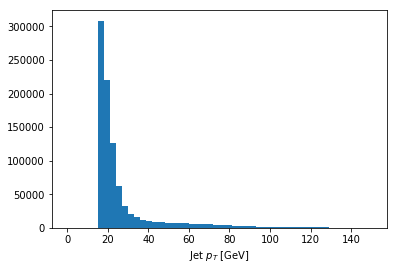

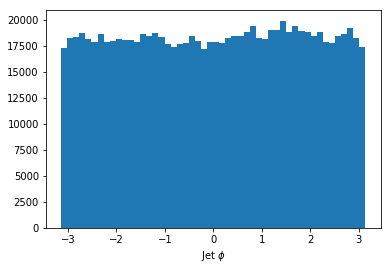

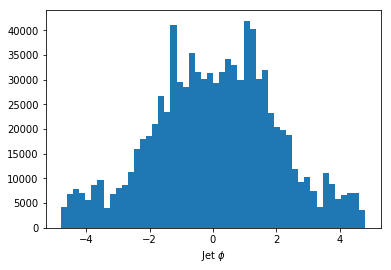

In [9]:
plt.hist(df.JetPt, bins=50,range=(0,150))
plt.xlabel('Jet $p_T$ [GeV]')
plt.show()
plt.hist(df.JetPhi, bins=50)
plt.xlabel('Jet $\phi$')
plt.show()
plt.hist(df.JetEta, bins=50)
plt.xlabel('Jet $\phi$')
plt.show()

### Including Run Number and Event Number

This is great - except that we often need to include the run number and event number in each of these rows for later debugging purposes. To do that, we have to modify the query a bit. Instead of splitting it accross many lines, we'll do it on one line here:

In [10]:
as_evt_jets = ds \
        .SelectMany('lambda e: e.Jets("AntiKt4EMTopoJets").Select(lambda j: (e.EventInfo("EventInfo"), j))') \
        .Select('lambda ji: (ji[0].runNumber(), ji[0].eventNumber(), ji[1].pt()/1000.0, ji[1].eta(), ji[1].phi())') \
        .AsPandasDF(('RunNumber', 'EventNumber', 'JetPt', 'JetEta', 'JetPhi'))

A few differences here!

- The first `SelectMany` statement is still playing the same roll. But it looks a lot more complex on the inside! Actually, it is very similar. Previously the `lambda` converted just `e.Jets("AntiKt4EMTopoJets")`. Now we've added a `Select` operator onto the end.
- As we saw previously, the `Select` operator just transforms the sequence from one thing into the other. In this case, it will transform the array of jets for the event into an array of tuples for the event. The first item in the tuple is the ATLAS `EventInfo` object, and the second is the ATLAS `Jet` object.
- As before the second outter `Select` translates that sequence of tuples into a tuple with run and event number, and the jet info. Note that it is referencing the items in the tuple created in the previous line.

The rest is as you would expect. We can then get the table:

In [11]:
ds_evt = as_evt_jets.value(executor=lambda a: use_exe_func_adl_server(a, node=node))

In [12]:
print (ds_evt.shape)

(916958, 5)


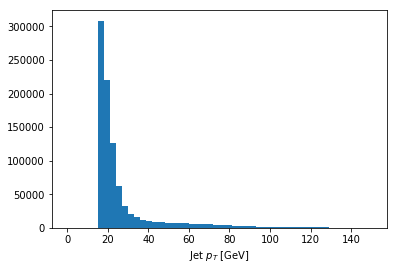

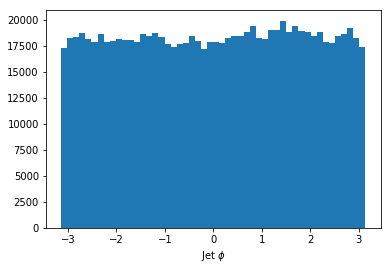

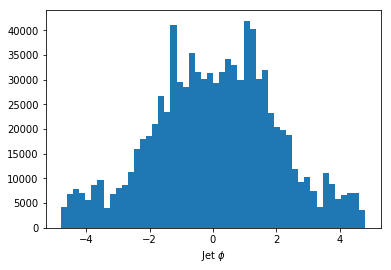

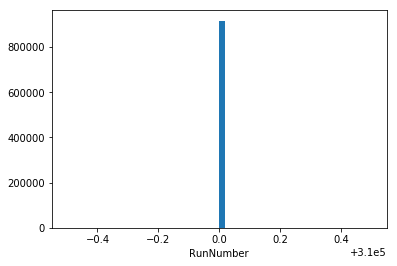

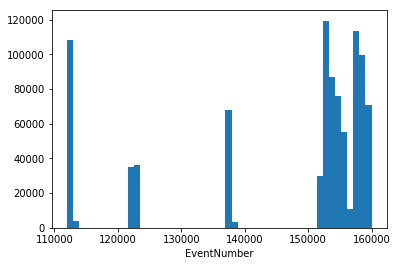

In [13]:
plt.hist(ds_evt.JetPt, bins=50,range=(0,150))
plt.xlabel('Jet $p_T$ [GeV]')
plt.show()
plt.hist(ds_evt.JetPhi, bins=50)
plt.xlabel('Jet $\phi$')
plt.show()
plt.hist(ds_evt.JetEta, bins=50)
plt.xlabel('Jet $\phi$')
plt.show()
plt.hist(ds_evt.RunNumber, bins=50)
plt.xlabel('RunNumber')
plt.show()
plt.hist(ds_evt.EventNumber, bins=50)
plt.xlabel('EventNumber')
plt.show()

## Getting the same data out per-event

Above we had an _entry_, or row, one per-jet. Lets get the same information, but get it per-event. This means that each row will contain a list of jets rather than a single jet. A few implications as compared to the above demo:

- The `SelectMany` operator will be replaced by a `Select` - we no longer wish to flatten the array of jets
- THe data that comes back is hierarchical, so the `pandas.DataFrame` is no longer an appropriate output. Instead, we need to use an `akward` or `jagged` array.

In [14]:
evts_awk = ds \
        .Select('lambda e: (e.EventInfo("EventInfo"), e.Jets("AntiKt4EMTopoJets"))') \
        .Select('lambda ei: (ei[0].runNumber(), ei[0].eventNumber(), ei[1].Select(lambda j: j.pt()/1000.0), ei[1].Select(lambda j: j.eta()), ei[1].Select(lambda j: j.phi()))') \
        .AsAwkwardArray(('RunNumber', 'EventNumber', 'JetPt', 'JetEta', 'JetPhi'))

Note that for each column we run a loop and perform a select to change an array of jets for the envet into an array of jet $p_T$, $\eta$, or $\phi$. This explicitly stores three arrays in the tuple for each event.

In [15]:
awk = evts_awk.value(executor=lambda a: use_exe_func_adl_server(a, node=node, quiet=True))

In [16]:
print (awk.keys())
print (awk[b'RunNumber'].shape)
print (awk[b'JetPt'].shape, awk[b'JetPt'].content.shape)

dict_keys([b'RunNumber', b'EventNumber', b'JetPt', b'JetEta', b'JetPhi'])
(70000,)
(70000,) (916958,)


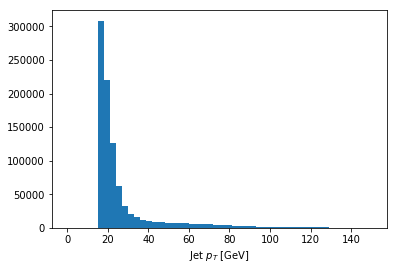

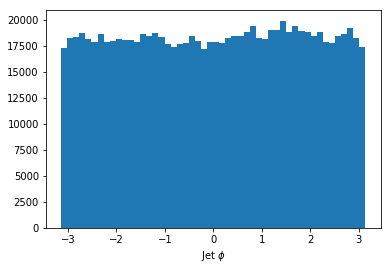

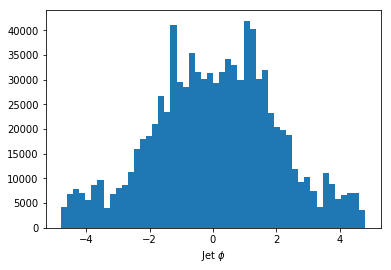

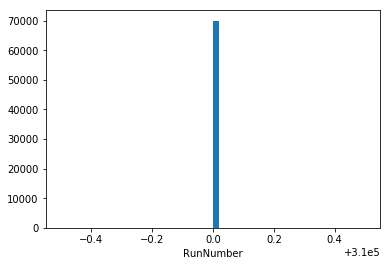

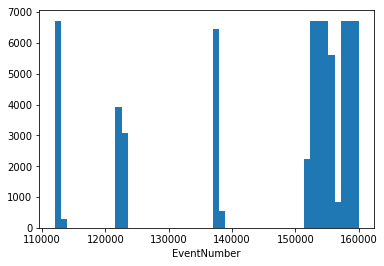

In [17]:
plt.hist(awk[b'JetPt'].content, bins=50,range=(0,150))
plt.xlabel('Jet $p_T$ [GeV]')
plt.show()
plt.hist(awk[b'JetPhi'].content, bins=50)
plt.xlabel('Jet $\phi$')
plt.show()
plt.hist(awk[b'JetEta'].content, bins=50)
plt.xlabel('Jet $\phi$')
plt.show()
plt.hist(awk[b'RunNumber'], bins=50)
plt.xlabel('RunNumber')
plt.show()
plt.hist(awk[b'EventNumber'], bins=50)
plt.xlabel('EventNumber')
plt.show()